# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).


**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'


In [2]:
import torch
import torchvision
import os
from torchvision.datasets import FakeData
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
from sklearn import metrics
import random


In [3]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True


In [4]:
torch.cuda.is_available()

True

In [5]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers= True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers= True)
fakeset = FakeData(size=1000, image_size=(3, 32, 32), transform=transform)
fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers= True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


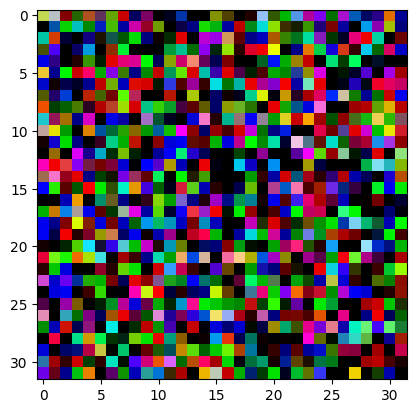

In [7]:
for data in fakeloader:
    x, y = data
    plt.imshow(x[0,:].permute(1,2,0))
    break

x.shape, trainset.classes[y[0]]

trainset.classes
class_dict = {class_name:id_class for id_class, class_name in enumerate(trainset.classes)} 

In [7]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # downsample
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # downsample
        
        self.flatten_dim = 256 * 8 * 8  # assuming input is 32x32
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # -> 32x32x32
        x = F.relu(self.conv2(x))   # -> 32x32x64
        x = F.relu(self.conv3(x))   # -> 32x32x128
        x = F.relu(self.conv4(x))   # -> 16x16x128
        x = F.relu(self.conv5(x))   # -> 8x8x256
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

loss =  nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

In [11]:
device

'cuda'

In [ ]:
load_resnet = False
load = False
if not load_resnet and not load:
    epochs = 50
    for e in range(epochs):
        running_loss = 0
        for it, data in enumerate (trainloader):
            x, y = data
            x, y = x.to(device), y.to(device)
            
            yp = model(x)
            l = loss(yp, y)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            running_loss += l.item()
            #if it % 100 == 0:
            #    print(it, l.item())
        print(e, running_loss/len(trainloader))
    torch.save(model.state_dict(), f'./cifar10_CNN.pth')      

0 1.7789149421560184
1 1.4448175472981484
2 1.3071257345511784
3 1.2077110661265185
4 1.1261968897736592
5 1.0507375407401862
6 0.9744820878328875
7 0.9037465099483499
8 0.832774361228699
9 0.7628627762465221
10 0.686014507051624
11 0.615203013581693
12 0.5389105093753551
13 0.46362369292227507
14 0.380393567330697
15 0.30415471702280555
16 0.239489449831226
17 0.17699372389203752
18 0.1323287708165548
19 0.099884953130694
20 0.0861181731352492
21 0.06988311364598897
22 0.059817592875407936
23 0.05395270514366267
24 0.04760631728593422
25 0.039761863427374824
26 0.04017812656619779
27 0.04635963918667411
28 0.03593771530748786
29 0.028593413447222823
30 0.03201819617239296
31 0.03534684379053924
32 0.028887280589326873
33 0.032206959568102225
34 0.01861196608208787
35 0.03276368698564923
36 0.027266188945068652
37 0.019952887098740817
38 0.03645037101162479
39 0.021219256328647514
40 0.017776486286691026
41 0.025959610017230902
42 0.02089738977931278
43 0.021265633007073226
44 0.027170

In [11]:
load = True

In [12]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.

if load:
    model = CNN().to(device)
    model.load_state_dict(torch.load('./cifar10_CNN.pth')) #fully trained
    #model.load_state_dict(torch.load(f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth'))

In [14]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.

if load_resnet:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
    model.eval()
    model.cuda()
    

In [13]:
#here we test the model on test data collecting all predictions
model.eval()
y_gt, y_pred = [], []
for it, data in enumerate (testloader):
    x, y = data
    x, y = x.to(device), y.to(device)

    yp = model(x)
    y_pred.append(yp.argmax(1))
    y_gt.append(y)

Accuracy: 0.6488999724388123


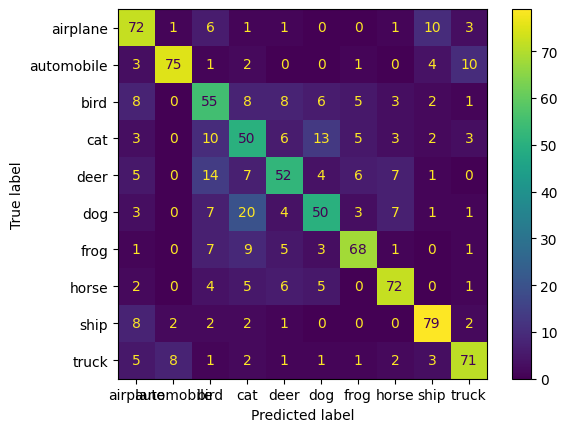

In [14]:
#Here we look at accuracy and confusion matrix
y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
print(f'Accuracy: {accuracy}')

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)

cmn = (100*cmn).astype(np.int32)
disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
disp.plot()
plt.show()


In [15]:
cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)
print(f'Per class accuracy: {np.diag(cmn).mean():.4f}')

Per class accuracy: 0.6489


In [16]:
for data in testloader:
    x, y = data
    #plt.imshow(x[0,:].permute(1,2,0))
    break

for data in fakeloader:
    xfake, _ = data
    #plt.imshow(x[0,:].permute(1,2,0))
    break

GT: 9, truck


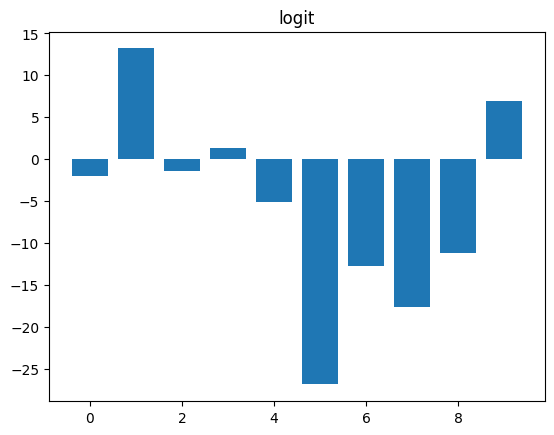

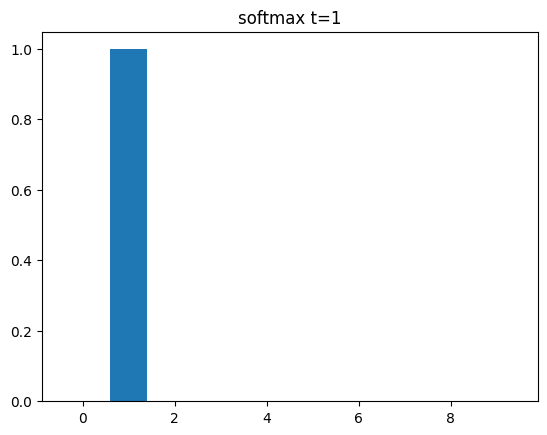

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


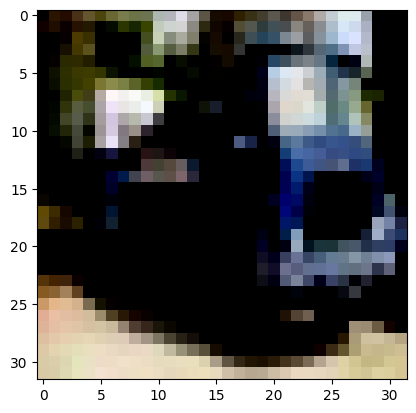

In [17]:
import random
#Example of logit and softmax output
#k=0#the kth sample of the batch
k=random.randint(0,x.shape[0])
print(f'GT: {y[k]}, {testset.classes[y[k]]}')#the corresponding label
output = model(x.cuda())
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

plt.imshow(x[k,:].permute(1,2,0))
plt.show()

In [21]:
x.shape

torch.Size([128, 3, 32, 32])

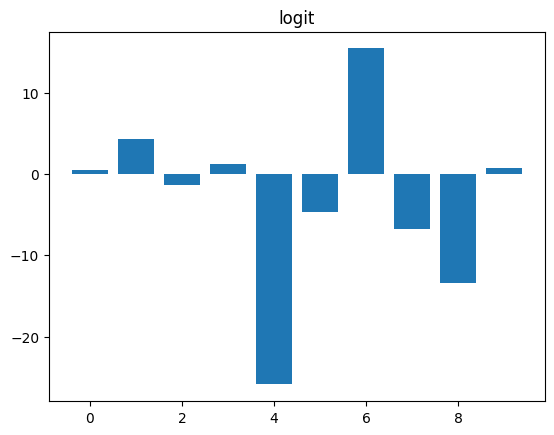

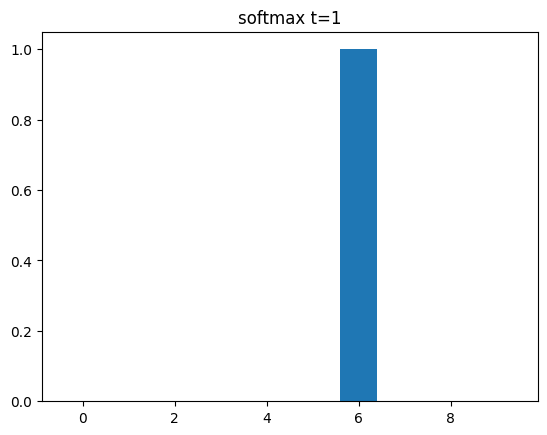

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


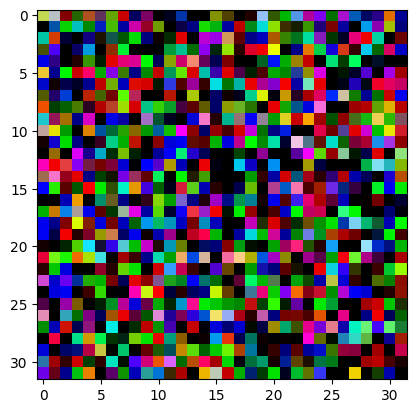

In [18]:
#Example of logit and softmax output
k=0 #the kth sample of the batch
output = model(xfake.cuda())
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

plt.imshow(xfake[0,:].permute(1,2,0))
plt.show()


    

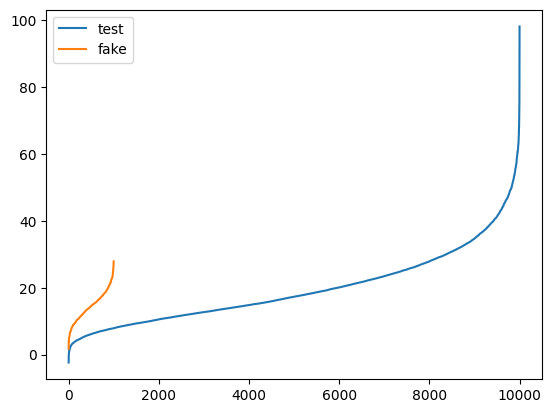

In [19]:
def max_logit(logit):
    s = logit.max(dim=1)[0] #get the max for each element of the batch
    return s

def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    s = s.max(dim=1)[0] #get the max for each element of the batch
    return s


def compute_scores(data_loader, score_fun):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device))
            s = score_fun(output)
            scores.append(s)
        scores_t = torch.cat(scores)
        return scores_t

temp=1
#scores_test = compute_scores(testloader, lambda l: max_softmax(l, T=temp))
#scores_fake = compute_scores(fakeloader, lambda l: max_softmax(l, T=temp))

scores_test = compute_scores(testloader, max_logit)
scores_fake = compute_scores(fakeloader, max_logit)

        
plt.plot(sorted(scores_test.cpu()),label='test')
plt.plot(sorted(scores_fake.cpu()),label='fake')
plt.legend()



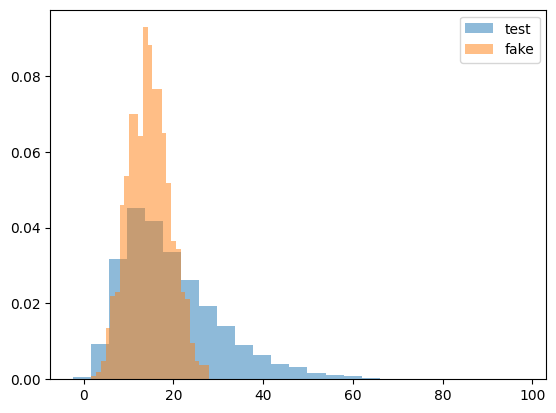

In [20]:
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25,label='test')
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25,label='fake')
plt.legend()
plt.show()


In [21]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [22]:
model_ae = Autoencoder().to(device)

mse_loss =  nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.0001)


In [23]:
epochs = 20
for e in range(epochs):
    running_loss = 0
    for it, data in enumerate (trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        
        z, x_rec = model_ae(x)
        l = mse_loss(x, x_rec)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        running_loss += l.item()
        #if it % 100 == 0:
        #    print(it, l.item())
    print(e, running_loss/len(trainloader))

0 0.3293707958801323
1 0.20018803059597454
2 0.18822018535393278
3 0.1782162362504798
4 0.1717649953978141
5 0.1689882332559132
6 0.16727538822252122
7 0.16547022881867635
8 0.16154025342610792
9 0.1596399238499839
10 0.1582500851139083
11 0.1571227150690525
12 0.1561404971591652
13 0.15526960393809297
14 0.15452777824895766
15 0.15395182622668077
16 0.15338826316701787
17 0.15293101531922665
18 0.15250352943492362
19 0.15210593623273513


In [24]:
model_ae.eval()
#use negative MSE since higher error means OOD
loss = nn.MSELoss(reduction='none')

scores_fake_ae = []
with torch.no_grad():
    for data in fakeloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_fake_ae.append(-score)
        
scores_fake_ae = torch.cat(scores_fake_ae)



scores_test_ae = []
with torch.no_grad():
    for data in testloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_test_ae.append(-score)
        
scores_test_ae = torch.cat(scores_test_ae)



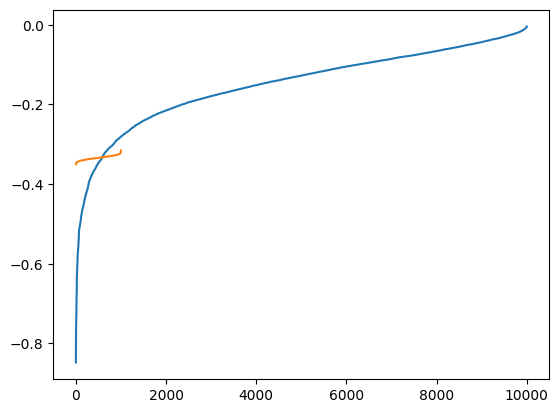

In [25]:
plt.plot(sorted(scores_test_ae.cpu()))
plt.plot(sorted(scores_fake_ae.cpu()))


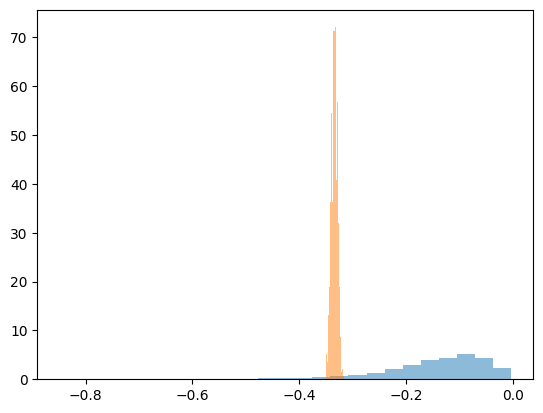

In [26]:
plt.hist(scores_test_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.hist(scores_fake_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



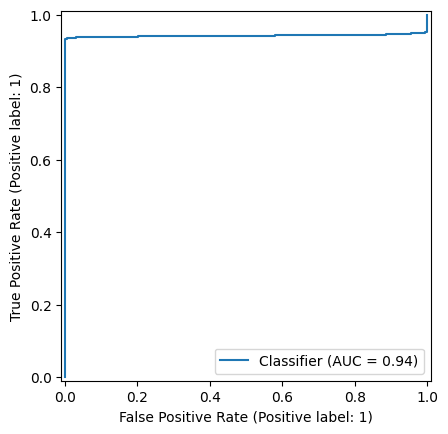

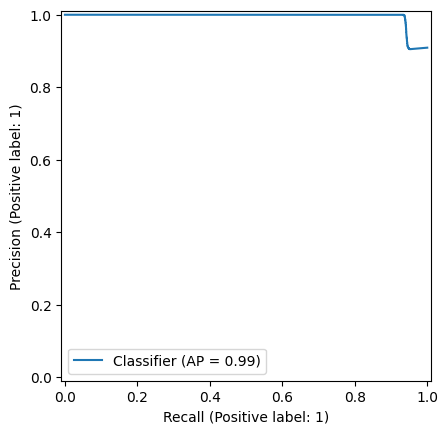

In [29]:
#AE performance
ypred =  torch.cat((scores_test_ae, scores_fake_ae))
y_test = torch.ones_like(scores_test_ae)
y_fake = torch.zeros_like(scores_fake_ae)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

metrics.PrecisionRecallDisplay.from_predictions(y.cpu(), ypred.cpu())

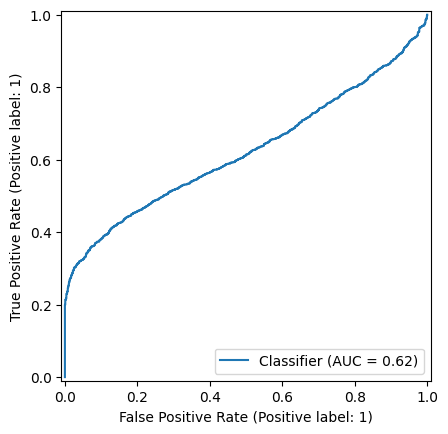

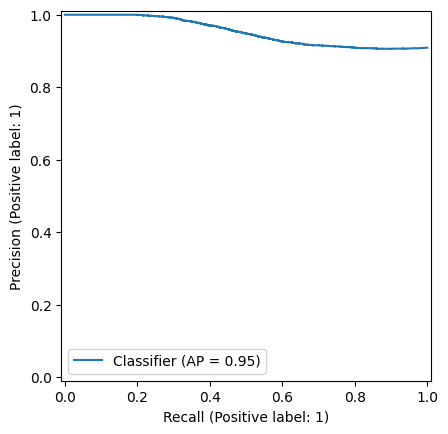

In [30]:
#logits or softmax performance
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

metrics.PrecisionRecallDisplay.from_predictions(y.cpu(), ypred.cpu())

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [83]:
# RESET MODEL

if load:
    model = CNN().to(device)
    model.load_state_dict(torch.load('./cifar10_CNN.pth')) #fully trained
    #model.load_state_dict(torch.load(f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth'))

In [84]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [85]:
for i,c in enumerate(testset.classes):
    print(i, c)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098028..1.0000001].


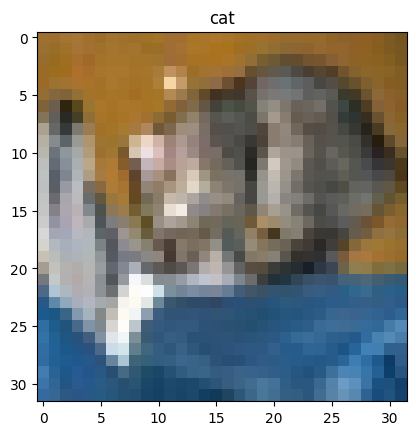

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098028..1.0039217].


Attack!!
3 3
2 3
Untargeted attack success! budget:4/255


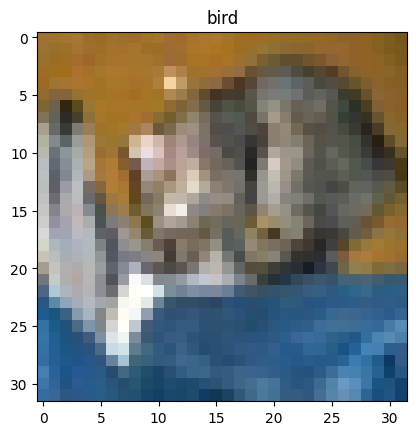

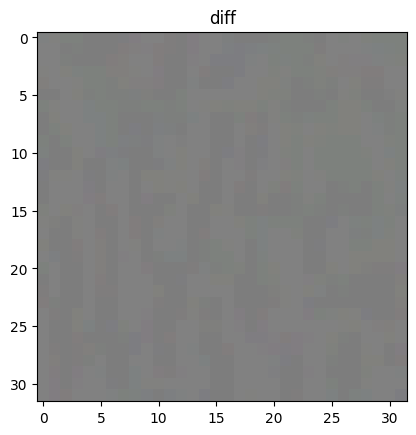

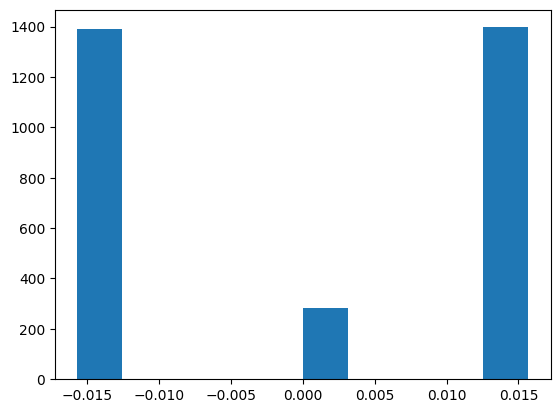

In [86]:
loss =  nn.CrossEntropyLoss()
model.train()
for data in testloader:
    x, y = data
    break
##########CONFIG###########

targeted_attack = False
target_label = class_dict['deer']
eps = 2/255 #set the budget for each step
sample_id = 0 #select id of test set sample to try to attack

#########END##############

x,y = x[sample_id].to(device), y[sample_id].to(device)

x = x[None,:]
y = y[None]

x.requires_grad=True  
#print(x)

before = x.clone()
output=model(x)
#print(output.argmax().item(),  y.item())
img = inv(x[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(testset.classes[output.argmax()])
plt.show()

if output.argmax().item()!=  y.item() or y.item()==target_label:
    print('classifier is already wrong or target label same as GT!')
else:
    done = False
    print('Attack!!')
    n=0
    #only attack if y==model(x)
    #target=torch.tensor(y).unsqueeze(0).cuda()
    if targeted_attack:
        target=torch.tensor(target_label).unsqueeze(0).cuda()
        print(f'target: {testset.classes[target.squeeze()]}')
   
    while not done: #untargeted attack until success!
    

        x.retain_grad()

        output=model(x)

        model.zero_grad()
        if targeted_attack:
            yt=target#targeted
        else:
            yt=y #untargeted
        
        l = loss(output,yt)
        l.backward()

        
        if targeted_attack:
            x = x - eps*torch.sign(x.grad)#fgsm targeted
        else:
            x = x + eps*torch.sign(x.grad)#fgsm untargeted
        
        n+=1

        print(output.argmax().item(),  y.item())
        if not targeted_attack and output.argmax().item()!=  y.item():
            print(f'Untargeted attack success! budget:{int(255*n*eps)}/255')
            done=True
        
        if targeted_attack and output.argmax().item() == target:
            
            print(f'Targeted attack({testset.classes[output.argmax()]}) success! budget:{int(255*n*eps)}/255')
            done=True
            
   
    img = inv(x.squeeze())
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(testset.classes[output.argmax()])
    plt.show()

    diff = (x-before)
    diffi = inv(diff[0])
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()

    plt.hist(diff_flat.detach().cpu())


In [87]:
x.shape

torch.Size([1, 3, 32, 32])

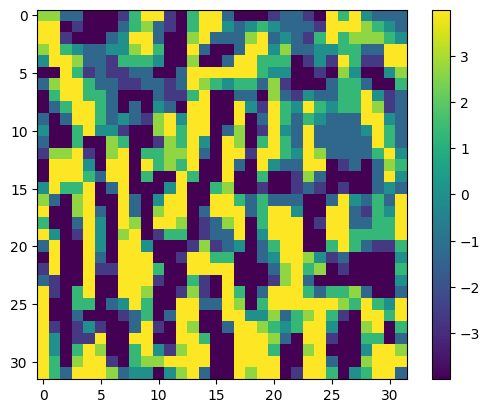

In [88]:
diff.squeeze().mean(0).shape
plt.imshow(255*diff.cpu().detach().squeeze().mean(0))
plt.colorbar()

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [112]:
def fgsm_attack(model, x, y, eps, targeted=False, target_label=None):
    x_adv = x.clone().detach().to(device)
    x_adv.requires_grad = True

    output = model(x_adv)
    loss_fn = nn.CrossEntropyLoss()

    if targeted:
        target = torch.full_like(y, target_label).to(device)
        loss = loss_fn(output, target)
    else:
        loss = loss_fn(output, y)

    model.zero_grad()
    loss.backward()

    if targeted:
        x_adv = x_adv - eps * torch.sign(x_adv.grad) #FGSM targheted
    else:
        x_adv = x_adv + eps * torch.sign(x_adv.grad) #FGSM targheted

    return x_adv.detach()

In [113]:
# Check Attack Success Rate for targeted and untargeted attack

# Targeted Attack Success Rate = (numero di x_adv classificati come target) / (numero totale di x_adv) * 100

# Untargeted Attack Success Rate= (numero di x_adv con predizione diversa da ground truth) / (numero totale di x_adv) * 100

def attack_success_rate(model, dataloader, eps, targeted=False, target_label=None):

    model.eval()
    total = 0
    success = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Adversarial examples
        adv_inputs = fgsm_attack(model, inputs, labels, eps, targeted=targeted, target_label=target_label)

        # Prediction
        outputs = model(adv_inputs)
        preds = outputs.argmax(dim=1)

        if targeted:
            # sum if prediction = target_label
            success += (preds == target_label).sum().item()
        else:
            # sum if prediction ≠ ground truth
            success += (preds != labels).sum().item()

        total += inputs.size(0)

    success_rate = 100 * success / total

    if targeted:
        print(f"Targeted Attack Success Rate towards class {testset.classes[target_label]}: {success_rate:.2f}%")
    else:
        print(f"Untargeted Attack Success Rate: {success_rate:.2f}%")

    return success_rate

In [114]:
# RESET MODEL.

if load:
    model = CNN().to(device)
    model.load_state_dict(torch.load('./cifar10_CNN.pth')) #fully trained
    #model.load_state_dict(torch.load(f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth'))

#### Before training attack succes rate

In [115]:
uasr = attack_success_rate(model, testloader, eps=2/255, targeted=False)

Untargeted Attack Success Rate: 55.87%


In [116]:
#Config
num_epochs = 10
eps = 2/255
targeted = False #True
target_label = None # class_dict['deer']

# Training loop con data augmentation

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        adv_inputs = fgsm_attack(model, inputs, labels, eps, targeted = targeted)
        combined_inputs = torch.cat([inputs, adv_inputs], dim=0)
        combined_labels = torch.cat([labels, labels], dim=0)

        # Forward
        outputs = model(combined_inputs)
        loss = loss_fn(outputs, combined_labels)

        # Backward & Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0

print("End training")

Epoch [1/10], Step [100/391], Loss: 1.5047
Epoch [1/10], Step [200/391], Loss: 0.8405
Epoch [1/10], Step [300/391], Loss: 0.7842
Epoch [2/10], Step [100/391], Loss: 0.4834
Epoch [2/10], Step [200/391], Loss: 0.5487
Epoch [2/10], Step [300/391], Loss: 0.6097
Epoch [3/10], Step [100/391], Loss: 0.3349
Epoch [3/10], Step [200/391], Loss: 0.3911
Epoch [3/10], Step [300/391], Loss: 0.4615
Epoch [4/10], Step [100/391], Loss: 0.2476
Epoch [4/10], Step [200/391], Loss: 0.3250
Epoch [4/10], Step [300/391], Loss: 0.3494
Epoch [5/10], Step [100/391], Loss: 0.1888
Epoch [5/10], Step [200/391], Loss: 0.2196
Epoch [5/10], Step [300/391], Loss: 0.2746
Epoch [6/10], Step [100/391], Loss: 0.1542
Epoch [6/10], Step [200/391], Loss: 0.1869
Epoch [6/10], Step [300/391], Loss: 0.2292
Epoch [7/10], Step [100/391], Loss: 0.1111
Epoch [7/10], Step [200/391], Loss: 0.1586
Epoch [7/10], Step [300/391], Loss: 0.1888
Epoch [8/10], Step [100/391], Loss: 0.1062
Epoch [8/10], Step [200/391], Loss: 0.1348
Epoch [8/10

#### After Training with untargeted adversarial sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098028..1.0000001].


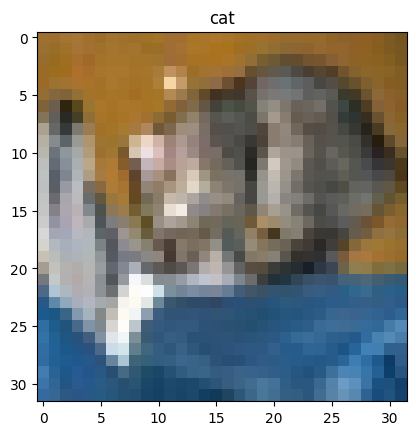

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.039215576..1.019608].


Attack!!
3 3
3 3
3 3
3 3
3 3
3 3
6 3
Untargeted attack success! budget:14/255


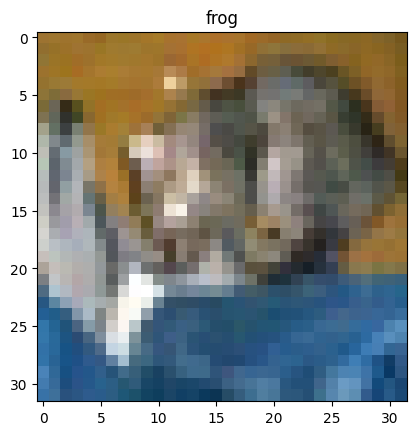

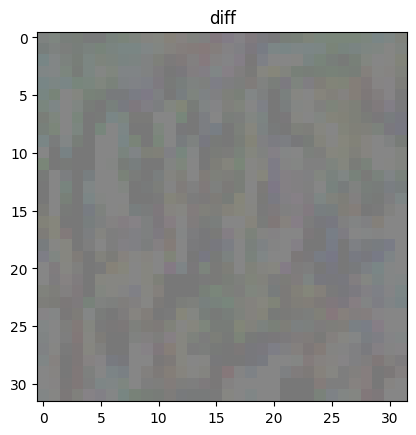

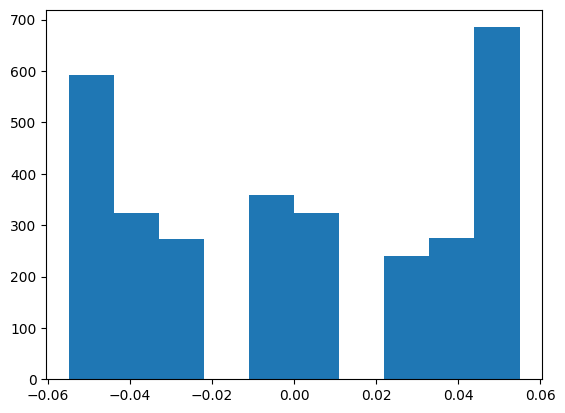

In [117]:
loss =  nn.CrossEntropyLoss()
model.train()
for data in testloader:
    x, y = data
    break
##########CONFIG###########

targeted_attack = False
target_label = class_dict['deer']
eps = 2/255 #set the budget for each step
sample_id = 0 #select id of test set sample to try to attack

#########END##############

x,y = x[sample_id].to(device), y[sample_id].to(device)

x = x[None,:]
y = y[None]

x.requires_grad=True  
#print(x)

before = x.clone()
output=model(x)
#print(output.argmax().item(),  y.item())
img = inv(x[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(testset.classes[output.argmax()])
plt.show()

if output.argmax().item()!=  y.item() or y.item()==target_label:
    print('classifier is already wrong or target label same as GT!')
else:
    done = False
    print('Attack!!')
    n=0
    #only attack if y==model(x)
    #target=torch.tensor(y).unsqueeze(0).cuda()
    if targeted_attack:
        target=torch.tensor(target_label).unsqueeze(0).cuda()
        print(f'target: {testset.classes[target.squeeze()]}')
   
    while not done: #untargeted attack until success!
    

        x.retain_grad()

        output=model(x)

        model.zero_grad()
        if targeted_attack:
            yt=target#targeted
        else:
            yt=y #untargeted
        
        l = loss(output,yt)
        l.backward()

        
        if targeted_attack:
            x = x - eps*torch.sign(x.grad)#fgsm targeted
        else:
            x = x + eps*torch.sign(x.grad)#fgsm untargeted
        
        n+=1

        print(output.argmax().item(),  y.item())
        if not targeted_attack and output.argmax().item()!=  y.item():
            print(f'Untargeted attack success! budget:{int(255*n*eps)}/255')
            done=True
        
        if targeted_attack and output.argmax().item() == target:
            
            print(f'Targeted attack({testset.classes[output.argmax()]}) success! budget:{int(255*n*eps)}/255')
            done=True
            
   
    img = inv(x.squeeze())
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(testset.classes[output.argmax()])
    plt.show()

    diff = (x-before)
    diffi = inv(diff[0])
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()

    plt.hist(diff_flat.detach().cpu())

#### Required more step to make the attack succede (untargeted adversarial sample)

In [120]:
untargeted_result = attack_success_rate(model, testloader, eps=2/255, targeted=False)

Untargeted Attack Success Rate: 48.58%


#### Attack Success Rate drop after training

---
### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


#### Reset model and train on targheted attack

In [121]:
# RESET MODEL

if load:
    model = CNN().to(device)
    model.load_state_dict(torch.load('./cifar10_CNN.pth')) #fully trained
    #model.load_state_dict(torch.load(f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth'))

#### Baseline for targeted attack (Same Target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098028..1.0000001].


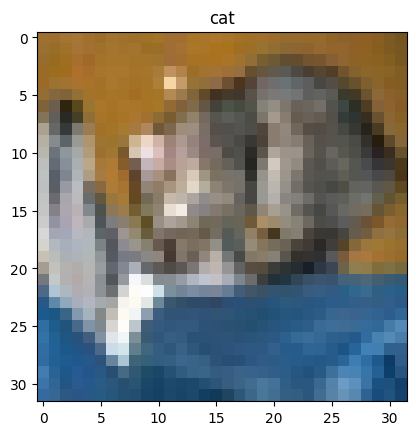

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.054901853..1.0078433].


Attack!!
target: deer
3 3
3 3
2 3
4 3
Targeted attack(deer) success! budget:8/255


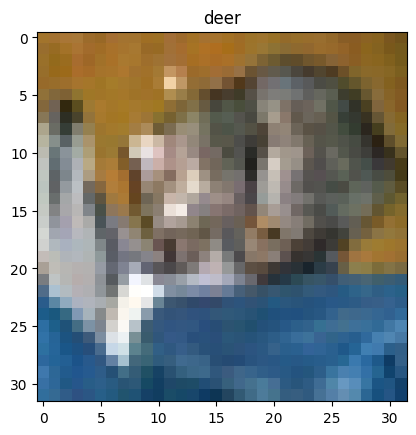

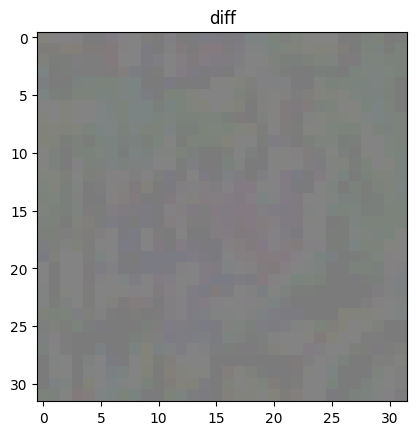

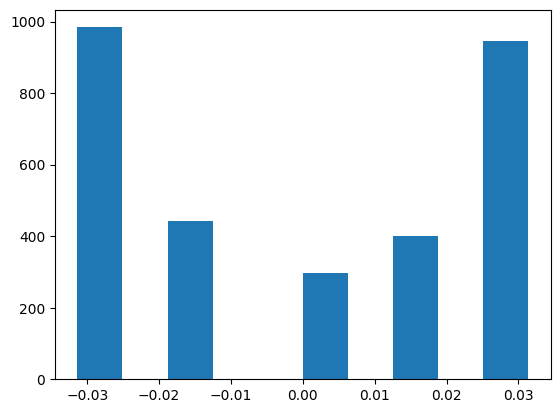

In [122]:
loss =  nn.CrossEntropyLoss()
model.train()
for data in testloader:
    x, y = data
    break
##########CONFIG###########

targeted_attack = True
target_label = class_dict['deer']
eps = 2/255 #set the budget for each step
sample_id = 0 #select id of test set sample to try to attack

#########END##############

x,y = x[sample_id].to(device), y[sample_id].to(device)

x = x[None,:]
y = y[None]

x.requires_grad=True  
#print(x)

before = x.clone()
output=model(x)
#print(output.argmax().item(),  y.item())
img = inv(x[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(testset.classes[output.argmax()])
plt.show()

if output.argmax().item()!=  y.item() or y.item()==target_label:
    print('classifier is already wrong or target label same as GT!')
else:
    done = False
    print('Attack!!')
    n=0
    #only attack if y==model(x)
    #target=torch.tensor(y).unsqueeze(0).cuda()
    if targeted_attack:
        target=torch.tensor(target_label).unsqueeze(0).cuda()
        print(f'target: {testset.classes[target.squeeze()]}')
   
    while not done: #untargeted attack until success!
    

        x.retain_grad()

        output=model(x)

        model.zero_grad()
        if targeted_attack:
            yt=target#targeted
        else:
            yt=y #untargeted
        
        l = loss(output,yt)
        l.backward()

        
        if targeted_attack:
            x = x - eps*torch.sign(x.grad)#fgsm targeted
        else:
            x = x + eps*torch.sign(x.grad)#fgsm untargeted
        
        n+=1

        print(output.argmax().item(),  y.item())
        if not targeted_attack and output.argmax().item()!=  y.item():
            print(f'Untargeted attack success! budget:{int(255*n*eps)}/255')
            done=True
        
        if targeted_attack and output.argmax().item() == target:
            
            print(f'Targeted attack({testset.classes[output.argmax()]}) success! budget:{int(255*n*eps)}/255')
            done=True
            
   
    img = inv(x.squeeze())
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(testset.classes[output.argmax()])
    plt.show()

    diff = (x-before)
    diffi = inv(diff[0])
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()

    plt.hist(diff_flat.detach().cpu())

#### Baseline for targeted attack (Different Target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098028..1.0000001].


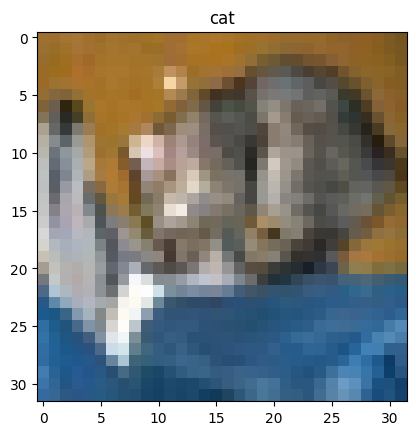

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.035294004..1.0078433].


Attack!!
target: ship
3 3
3 3
2 3
8 3
Targeted attack(ship) success! budget:8/255


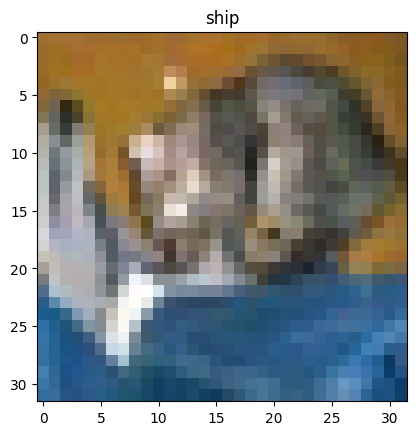

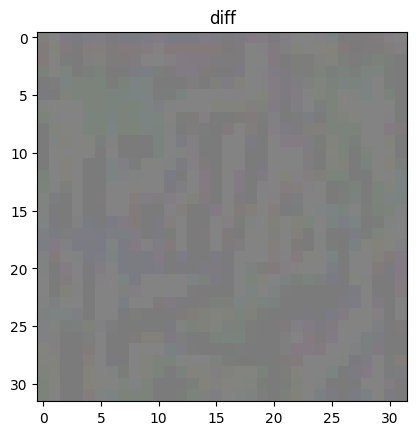

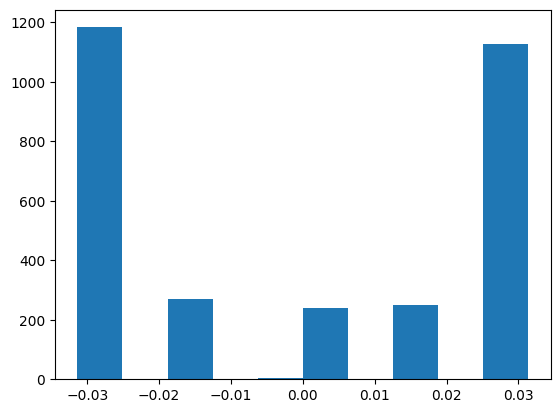

In [123]:
loss =  nn.CrossEntropyLoss()
model.train()
for data in testloader:
    x, y = data
    break
##########CONFIG###########

targeted_attack = True
target_label = class_dict['ship']
eps = 2/255 #set the budget for each step
sample_id = 0 #select id of test set sample to try to attack

#########END##############

x,y = x[sample_id].to(device), y[sample_id].to(device)

x = x[None,:]
y = y[None]

x.requires_grad=True  
#print(x)

before = x.clone()
output=model(x)
#print(output.argmax().item(),  y.item())
img = inv(x[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(testset.classes[output.argmax()])
plt.show()

if output.argmax().item()!=  y.item() or y.item()==target_label:
    print('classifier is already wrong or target label same as GT!')
else:
    done = False
    print('Attack!!')
    n=0
    #only attack if y==model(x)
    #target=torch.tensor(y).unsqueeze(0).cuda()
    if targeted_attack:
        target=torch.tensor(target_label).unsqueeze(0).cuda()
        print(f'target: {testset.classes[target.squeeze()]}')
   
    while not done: #untargeted attack until success!
    

        x.retain_grad()

        output=model(x)

        model.zero_grad()
        if targeted_attack:
            yt=target#targeted
        else:
            yt=y #untargeted
        
        l = loss(output,yt)
        l.backward()

        
        if targeted_attack:
            x = x - eps*torch.sign(x.grad)#fgsm targeted
        else:
            x = x + eps*torch.sign(x.grad)#fgsm untargeted
        
        n+=1

        print(output.argmax().item(),  y.item())
        if not targeted_attack and output.argmax().item()!=  y.item():
            print(f'Untargeted attack success! budget:{int(255*n*eps)}/255')
            done=True
        
        if targeted_attack and output.argmax().item() == target:
            
            print(f'Targeted attack({testset.classes[output.argmax()]}) success! budget:{int(255*n*eps)}/255')
            done=True
            
   
    img = inv(x.squeeze())
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(testset.classes[output.argmax()])
    plt.show()

    diff = (x-before)
    diffi = inv(diff[0])
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()

    plt.hist(diff_flat.detach().cpu())

#### Targeted Attack Success Rate before training for each class

Baseline Attacked Deer class tasr = 19.27%

In [106]:
tasr_results = {}

for class_name, target_label in class_dict.items():
    tasr = attack_success_rate(
        model, 
        testloader, 
        eps=2/255, 
        targeted=True, 
        target_label=target_label
    )
    tasr_results[class_name] = tasr

Targeted Attack Success Rate towards class airplane: 19.67%
Targeted Attack Success Rate towards class automobile: 12.75%
Targeted Attack Success Rate towards class bird: 22.24%
Targeted Attack Success Rate towards class cat: 22.10%
Targeted Attack Success Rate towards class deer: 19.27%
Targeted Attack Success Rate towards class dog: 17.67%
Targeted Attack Success Rate towards class frog: 16.34%
Targeted Attack Success Rate towards class horse: 16.75%
Targeted Attack Success Rate towards class ship: 15.86%
Targeted Attack Success Rate towards class truck: 14.74%


#### For comparison untargeted attack Success Rate before training 

In [124]:
untargeted_result = attack_success_rate(model, testloader, eps=2/255, targeted=False)

Untargeted Attack Success Rate: 55.87%


In [125]:
#Config
num_epochs = 10
eps = 2/255
targeted = True
target_label = class_dict['deer']

# Training loop con data augmentation

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        adv_inputs = fgsm_attack(model, inputs, labels, eps, targeted = targeted, target_label = target_label)
        combined_inputs = torch.cat([inputs, adv_inputs], dim=0)
        combined_labels = torch.cat([labels, labels], dim=0)

        # Forward
        outputs = model(combined_inputs)
        loss = loss_fn(outputs, combined_labels)

        # Backward & Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0

print("End training")

Epoch [1/10], Step [100/391], Loss: 0.9800
Epoch [1/10], Step [200/391], Loss: 0.5266
Epoch [1/10], Step [300/391], Loss: 0.5326
Epoch [2/10], Step [100/391], Loss: 0.3114
Epoch [2/10], Step [200/391], Loss: 0.3749
Epoch [2/10], Step [300/391], Loss: 0.4106
Epoch [3/10], Step [100/391], Loss: 0.2357
Epoch [3/10], Step [200/391], Loss: 0.2744
Epoch [3/10], Step [300/391], Loss: 0.3056
Epoch [4/10], Step [100/391], Loss: 0.1681
Epoch [4/10], Step [200/391], Loss: 0.2091
Epoch [4/10], Step [300/391], Loss: 0.2586
Epoch [5/10], Step [100/391], Loss: 0.1322
Epoch [5/10], Step [200/391], Loss: 0.1603
Epoch [5/10], Step [300/391], Loss: 0.1858
Epoch [6/10], Step [100/391], Loss: 0.1127
Epoch [6/10], Step [200/391], Loss: 0.1251
Epoch [6/10], Step [300/391], Loss: 0.1470
Epoch [7/10], Step [100/391], Loss: 0.1022
Epoch [7/10], Step [200/391], Loss: 0.1019
Epoch [7/10], Step [300/391], Loss: 0.1395
Epoch [8/10], Step [100/391], Loss: 0.0791
Epoch [8/10], Step [200/391], Loss: 0.1053
Epoch [8/10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098028..1.0000001].


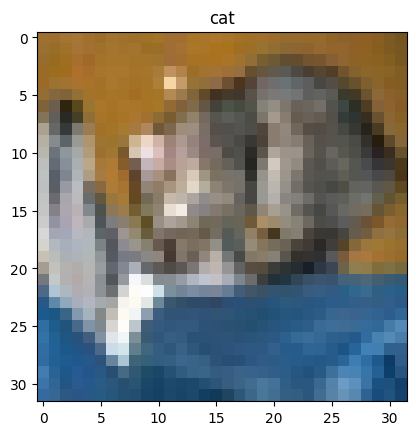

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.027450867..1.0156864].


Attack!!
target: deer
3 3
3 3
3 3
3 3
3 3
4 3
Targeted attack(deer) success! budget:12/255


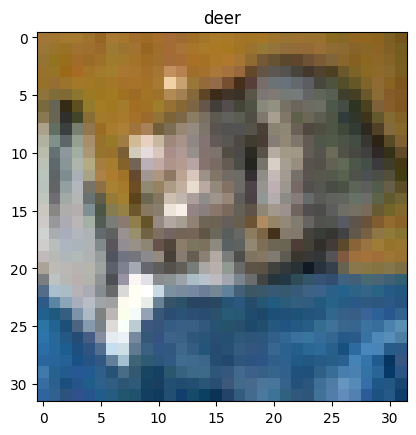

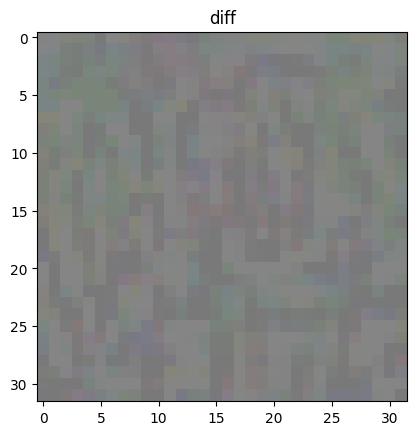

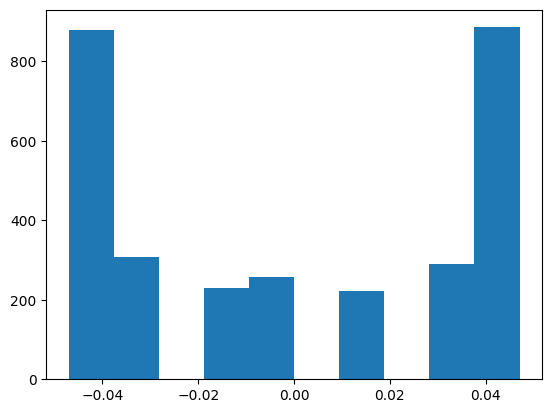

In [ ]:
loss =  nn.CrossEntropyLoss()
model.train()
for data in testloader:
    x, y = data
    break
##########CONFIG###########

targeted_attack = True
target_label = class_dict['deer']
eps = 2/255 #set the budget for each step
sample_id = 0 #select id of test set sample to try to attack

#########END##############

x,y = x[sample_id].to(device), y[sample_id].to(device)

x = x[None,:]
y = y[None]

x.requires_grad=True  
#print(x)

before = x.clone()
output=model(x)
#print(output.argmax().item(),  y.item())
img = inv(x[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(testset.classes[output.argmax()])
plt.show()

if output.argmax().item()!=  y.item() or y.item()==target_label:
    print('classifier is already wrong or target label same as GT!')
else:
    done = False
    print('Attack!!')
    n=0
    #only attack if y==model(x)
    #target=torch.tensor(y).unsqueeze(0).cuda()
    if targeted_attack:
        target=torch.tensor(target_label).unsqueeze(0).cuda()
        print(f'target: {testset.classes[target.squeeze()]}')
   
    while not done: #untargeted attack until success!
    

        x.retain_grad()

        output=model(x)

        model.zero_grad()
        if targeted_attack:
            yt=target#targeted
        else:
            yt=y #untargeted
        
        l = loss(output,yt)
        l.backward()

        
        if targeted_attack:
            x = x - eps*torch.sign(x.grad)#fgsm targeted
        else:
            x = x + eps*torch.sign(x.grad)#fgsm untargeted
        
        n+=1

        print(output.argmax().item(),  y.item())
        if not targeted_attack and output.argmax().item()!=  y.item():
            print(f'Untargeted attack success! budget:{int(255*n*eps)}/255')
            done=True
        
        if targeted_attack and output.argmax().item() == target:
            
            print(f'Targeted attack({testset.classes[output.argmax()]}) success! budget:{int(255*n*eps)}/255')
            done=True
            
   
    img = inv(x.squeeze())
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(testset.classes[output.argmax()])
    plt.show()

    diff = (x-before)
    diffi = inv(diff[0])
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()
    
    plt.hist(diff_flat.detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098028..1.0000001].


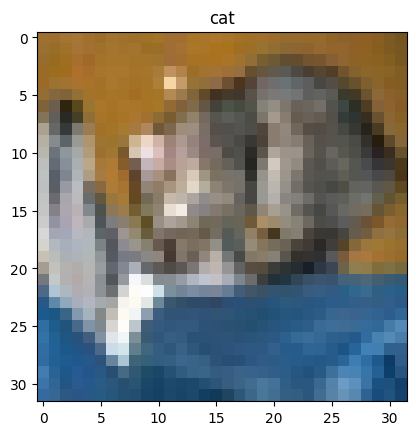

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.027450867..1.0117648].


Attack!!
target: ship
3 3
3 3
3 3
3 3
3 3
8 3
Targeted attack(ship) success! budget:12/255


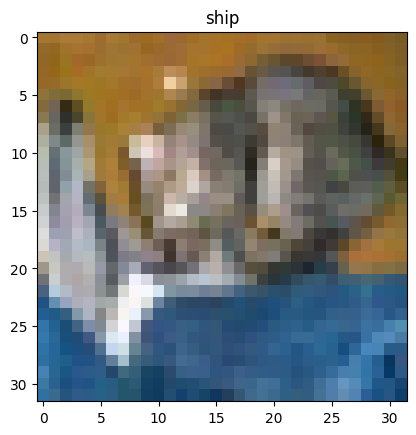

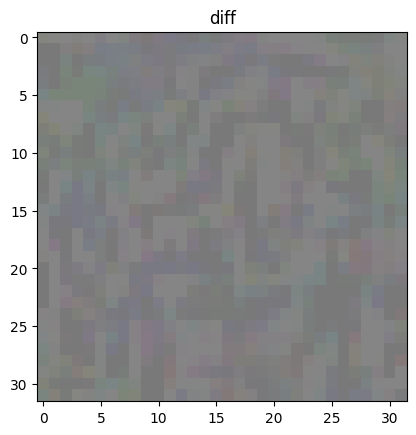

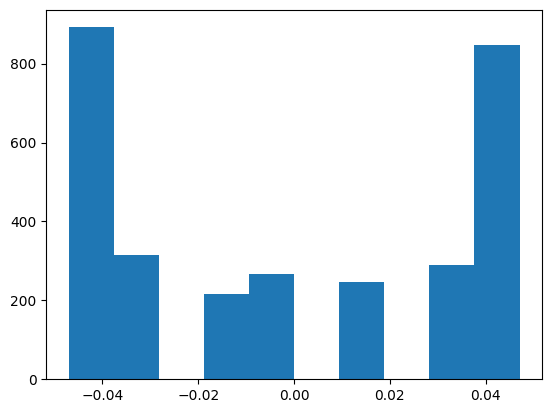

In [127]:
loss =  nn.CrossEntropyLoss()
model.train()
for data in testloader:
    x, y = data
    break
##########CONFIG###########

targeted_attack = True
target_label = class_dict['ship']
eps = 2/255 #set the budget for each step
sample_id = 0 #select id of test set sample to try to attack

#########END##############

x,y = x[sample_id].to(device), y[sample_id].to(device)

x = x[None,:]
y = y[None]

x.requires_grad=True  
#print(x)

before = x.clone()
output=model(x)
#print(output.argmax().item(),  y.item())
img = inv(x[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(testset.classes[output.argmax()])
plt.show()

if output.argmax().item()!=  y.item() or y.item()==target_label:
    print('classifier is already wrong or target label same as GT!')
else:
    done = False
    print('Attack!!')
    n=0
    #only attack if y==model(x)
    #target=torch.tensor(y).unsqueeze(0).cuda()
    if targeted_attack:
        target=torch.tensor(target_label).unsqueeze(0).cuda()
        print(f'target: {testset.classes[target.squeeze()]}')
   
    while not done: #untargeted attack until success!
    

        x.retain_grad()

        output=model(x)

        model.zero_grad()
        if targeted_attack:
            yt=target#targeted
        else:
            yt=y #untargeted
        
        l = loss(output,yt)
        l.backward()

        
        if targeted_attack:
            x = x - eps*torch.sign(x.grad)#fgsm targeted
        else:
            x = x + eps*torch.sign(x.grad)#fgsm untargeted
        
        n+=1

        print(output.argmax().item(),  y.item())
        if not targeted_attack and output.argmax().item()!=  y.item():
            print(f'Untargeted attack success! budget:{int(255*n*eps)}/255')
            done=True
        
        if targeted_attack and output.argmax().item() == target:
            
            print(f'Targeted attack({testset.classes[output.argmax()]}) success! budget:{int(255*n*eps)}/255')
            done=True
            
   
    img = inv(x.squeeze())
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(testset.classes[output.argmax()])
    plt.show()

    diff = (x-before)
    diffi = inv(diff[0])
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()

    plt.hist(diff_flat.detach().cpu())

#### Required more step to make the attack succede both for same and different target
is always true?

#### Targeted Attack Success Rate After training for each class

In [128]:
tasr_results = {}

for class_name, target_label in class_dict.items():
    tasr = attack_success_rate(
        model, 
        testloader, 
        eps=2/255, 
        targeted=True, 
        target_label=target_label
    )
    tasr_results[class_name] = tasr

Targeted Attack Success Rate towards class airplane: 15.31%
Targeted Attack Success Rate towards class automobile: 12.82%
Targeted Attack Success Rate towards class bird: 24.37%
Targeted Attack Success Rate towards class cat: 19.91%
Targeted Attack Success Rate towards class deer: 14.95%
Targeted Attack Success Rate towards class dog: 15.56%
Targeted Attack Success Rate towards class frog: 22.44%
Targeted Attack Success Rate towards class horse: 16.16%
Targeted Attack Success Rate towards class ship: 16.99%
Targeted Attack Success Rate towards class truck: 14.85%


#### Targeted Attack Success Rate before training for each class (Baseline)

Targeted Attack Success Rate towards class airplane: 19.67%
<br>
Targeted Attack Success Rate towards class automobile: 12.75%
<br>
Targeted Attack Success Rate towards class bird: 22.24%
<br>
Targeted Attack Success Rate towards class cat: 22.10%
<br>
Targeted Attack Success Rate towards class deer: 19.27%
<br>
Targeted Attack Success Rate towards class dog: 17.67%
<br>
Targeted Attack Success Rate towards class frog: 16.34%
<br>
Targeted Attack Success Rate towards class horse: 16.75%
<br>
Targeted Attack Success Rate towards class ship: 15.86%
<br>
Targeted Attack Success Rate towards class truck: 14.74%
<br>

Targhet class became more robust to attack as expected but is not always true for all class, after training some class became more vulnerable to attacks

#### Overall performance for targeted training?

In [129]:
untargeted_result = attack_success_rate(model, testloader, eps=2/255, targeted=False)

Untargeted Attack Success Rate: 52.55%


A bit better but untargeted training cleary outperform in general scenario